# Visualising taxa abundance

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(compositions)
require(ggpubr)
require(see)
require(doParallel)
require(Rtsne)
require(vegan)
require(VennDiagram)
registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

## Pre-process data

### Load and parse data

In [2]:
get_meta_cols <- function(meta, meta_regex, to_exclude) {
    meta_cols <- colnames(meta)[grep(meta_regex, colnames(meta))]
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


remove_cols <- function(df, col_to_exclude) {
    return(df %>% select(-all_of(col_to_exclude)))
}


load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}


otu_to_PA <- function(df, read_threshold) {
    prev_read <- df %>%
        column_to_rownames("npm_research_id")
    
    prev_read[prev_read <= read_threshold] <- 0
    prev_read[prev_read > read_threshold] <- 1

    return(prev_read)
}


RA_to_PA <- function(RA_df, PA_threshold) {
    prev_RA <- RA_df %>% column_to_rownames("npm_research_id")
    prev_RA[prev_RA <= PA_threshold] <- 0
    prev_RA[prev_RA > PA_threshold] <- 1
    
    return(prev_RA)
}


RA_to_clr <- function(df) {
    row_names <- df$npm_research_id
    clr_df <- clr(df %>% select(where(is.numeric)))
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(clr_df, check.names = F)))
}


get_prev_df <- function(df) {
    RA_df <- otu_to_RA(df)
    prev_RA <- RA_to_PA(RA_df, PA_threshold = 0.01)
    prev_read <- otu_to_PA(df, read_threshold = 10)
    prev_df <- as.data.frame(prev_read & prev_RA)
    prev_df <- filter_taxa_by_presence(prev_df, presence_t = 0) # Remove taxa that are not present in any samples
    prev_df <- prev_df %>% rownames_to_column("npm_research_id")
    return(prev_df)
}


filter_taxa_by_presence <- function(prev_df, presence_t) {
    taxa_counts <- apply(prev_df, 2, sum)
    to_keep <- names(taxa_counts)[taxa_counts > presence_t]
    return(prev_df %>% select(all_of(to_keep)))
}

In [3]:
rank <- "S"
n_subset <- 9999
human <- "Homo sapiens"

to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain) %>%
    as_tibble()

meta_cols <- get_meta_cols(meta, 
                           meta_regex = "kit|flow_cell|site_supplying", 
                           to_exclude = c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id"))


species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>%
      filter(npm_research_id %in% to_retain) %>%
    as_tibble()

species_df <- remove_cols(species_df, c(human, "unclassified"))
prev_df <- get_prev_df(species_df)

### Remove contaminants and renormalise

In [4]:
column <- "extraction_kit"
contam_df <- fread(str_glue("results/decontamination/post_hoc_fine_grain/{column}_fine_grain_results.csv"))
contam_df

meta_col,level,n_samples,n_prev_contams,n_all_contams,contams
<chr>,<chr>,<int>,<int>,<int>,<chr>
extraction_kit,abGENIX Whole Blood Genomic DNA Extraction Kit,2280,10,28,Acinetobacter johnsonii|Brevundimonas diminuta|Brevundimonas naejangsanensis|Brevundimonas sp. DS20|Brevundimonas sp. LM2|Caulobacter mirabilis|Microbacterium aurum|Microbacterium chocolatum|Microbacterium foliorum|Microbacterium hominis|Microbacterium paludicola|Microbacterium pygmaeum|Microbacterium sp. 10M-3C3|Microbacterium sp. ABRD_28|Microbacterium sp. LKL04|Microbacterium sp. No. 7|Microbacterium sp. PM5|Pseudomonas aeruginosa|Alcaligenes aquatilis|Alcaligenes faecalis|Caulobacter flavus|Caulobacter henricii|Caulobacter segnis|Caulobacter sp. K31|Caulobacter vibrioides|Microbacterium sp. BH-3-3-3|Microbacterium testaceum|Sphingomonas melonis
extraction_kit,"Chemagic DNA Blood Kit (Perkin Elmer, MA)",1040,11,40,Bosea sp. Tri-49|Clavibacter michiganensis|Gordonia sp. KTR9|Gordonia terrae|Microbacterium sp. Y-01|Paracoccus aminovorans|Paracoccus contaminans|Paracoccus sp. CBA4604|Paracoccus sp. SC2-6|Paracoccus yeei|Paracoccus zhejiangensis|Phreatobacter cathodiphilus|Pseudomonas alcaligenes|Pseudomonas entomophila|Pseudomonas fluorescens|Pseudomonas fulva|Pseudomonas koreensis|Pseudomonas monteilii|Pseudomonas oryzihabitans|Pseudomonas plecoglossicida|Pseudomonas psychrotolerans|Pseudomonas putida|Pseudomonas sp. 02C 26|Pseudomonas sp. CMR5c|Pseudomonas sp. LTJR-52|Pseudomonas sp. NC02|Pseudomonas tolaasii|Stenotrophomonas maltophilia|Stenotrophomonas sp. LM091|Bordetella genomosp. 13|Bradyrhizobium sp. SK17|Microcella alkaliphila|Pseudomonas aeruginosa|Pseudomonas alcaliphila|Pseudomonas mendocina|Pseudomonas pseudoalcaligenes|Pseudomonas sihuiensis|Pseudomonas sp. LPH1|Pseudomonas sp. phDV1|Pseudomonas stutzeri
extraction_kit,Maxwell RSC Blood DNA Kit (AS1400),2113,26,59,Afipia sp. GAS231|Altererythrobacter sp. B11|Bradyrhizobium japonicum|Bradyrhizobium oligotrophicum|Bradyrhizobium ottawaense|Bradyrhizobium sp.|Bradyrhizobium sp. 3 85S1MB|Bradyrhizobium sp. CCGE-LA001|Bradyrhizobium sp. ORS 278|Bradyrhizobium sp. ORS 285|Bradyrhizobium sp. ORS 3257|Bradyrhizobium sp. S23321|Brevundimonas diminuta|Caulobacter flavus|Caulobacter mirabilis|Nitrobacter hamburgensis|Nitrobacter winogradskyi|Pannonibacter phragmitetus|Sphingobium baderi|Sphingobium cloacae|Sphingobium herbicidovorans|Sphingobium hydrophobicum|Sphingobium sp. RAC03|Sphingobium sp. SCG-1|Sphingomonas indica|Sphingomonas melonis|Sphingomonas sp. JJ-A5|Sphingomonas sp. MM-1|Sphingomonas sp. NIC1|Sphingopyxis granuli|Sphingopyxis macrogoltabida|Sphingopyxis sp. WS5A3p|Xanthobacter autotrophicus|Bradyrhizobiaceae bacterium SG-6C|Bradyrhizobium diazoefficiens|Bradyrhizobium erythrophlei|Bradyrhizobium icense|Bradyrhizobium lablabi|Bradyrhizobium sp. BTAi1|Bradyrhizobium sp. SK17|Brevundimonas sp. GW460-12-10-14-LB2|Brevundimonas vesicularis|Devosia sp. H5989|Methylobacterium brachiatum|Methylobacterium currus|Oligotropha carboxidovorans|Rhodopseudomonas palustris|Sphingobium sp. YG1|Sphingobium yanoikuyae|Sphingomonas hengshuiensis|Sphingomonas koreensis|Sphingomonas panacis|Sphingomonas sanxanigenens|Sphingomonas sp. Cra20|Sphingomonas sp. FARSPH|Sphingomonas sp. LK11|Sphingomonas sp. LM7|Sphingomonas taxi|Sphingomonas wittichii
extraction_kit,QIAsymphony DSP DNA Mini Kit (192),593,15,45,Afipia sp. GAS231|Altererythrobacter sp. B11|Bradyrhizobium diazoefficiens|Bradyrhizobium erythrophlei|Bradyrhizobium icense|Bradyrhizobium japonicum|Bradyrhizobium lablabi|Bradyrhizobium oligotrophicum|Bradyrhizobium sp. BTAi1|Bradyrhizobium sp. CCGE-LA001|Bradyrhizobium sp. ORS 285|Bradyrhizobium sp. SK17|Caulobacter flavus|Devosia sp. H5989|Nitrobacter hamburgensis|Oligotropha carboxidovorans|Sphingobium baderi|Sphingobium cloacae|Sphingobium herbicidovorans|Sphingobium hydrophobicum|Sphingobium sp. RAC03|Sphingobium sp. SCG-1|Sphingomonas indica|Sphingomonas melonis|Sphingomonas sp. JJ-A5|Sphingomonas sp. MM

#### Set 'absent' taxa to zero

In [5]:
species_filt <- species_df %>% 
    select(all_of(colnames(prev_df))) %>%
    column_to_rownames("npm_research_id")

prev_bool_df <- prev_df %>%
    column_to_rownames("npm_research_id")

for(i in seq(ncol(species_filt))) {
    species_filt[!prev_bool_df[, i], i] <- 0
}

species_filt <- species_filt %>% rownames_to_column("npm_research_id")

dat_meta <- species_filt %>%
    left_join(meta)

Joining, by = "npm_research_id"



#### Set contaminants to zero in affected levels

In [6]:
for(i in seq(nrow(contam_df))) {
# i <- 1
    level <- contam_df[i, ]$level
    contam_string <- contam_df[i, ]$contams
    contams <- unlist(str_split(contam_string, "\\|"))
    
    dat_meta[dat_meta[, column] == level, contams] <- 0
}

# # Check
# taxon <- "Microbacterium aurum"
# dat_meta %>% 
#     filter(!grepl("abGENIX", extraction_kit)) %>%
#     summarise(max = max(get(taxon)))

# dat_meta %>% 
#     filter(grepl("abGENIX", extraction_kit)) %>%
#     summarise(max = max(get(taxon)))

# Get zeroed read count and prevalence matrix
meta_cols_to_remove <- colnames(meta)[colnames(meta) != "npm_research_id"]
species_zeroed <- dat_meta %>% 
    select(-all_of(meta_cols_to_remove))
prev_zeroed <- get_prev_df(species_zeroed)

### Simple batch filter

In [7]:
taxa_vec <- colnames(prev_zeroed) 
taxa_vec <- taxa_vec[taxa_vec != "npm_research_id"]

In [8]:
result_df <- tibble(taxa = taxa_vec)

for(column in meta_cols) {
    res <- prev_zeroed %>% 
        left_join(meta %>% select(all_of(c("npm_research_id", column)))) %>%
        select(-npm_research_id) %>%
        pivot_longer(!column, names_to = "taxa", values_to = "presence") %>%
        filter(presence) %>%
        group_by(taxa) %>%
        summarise(n_batches = n_distinct(get(column)))  # Count number of batches in each column
    colnames(res)[2] <- column

    result_df <- result_df %>%
        left_join(res, "taxa")
}

result_df <- result_df %>% column_to_rownames("taxa")
result_df[result_df <= 1] <- 0
result_df[result_df > 1] <- 1

# Parse results
row_sums <- rowSums(result_df)
parsed_df <- tibble(taxa = names(row_sums), n_cols = row_sums)

prev_stats <- apply(prev_zeroed[, 2:ncol(prev_zeroed)], 2, sum) / nrow(prev_zeroed)
overall_prev <- data.frame(taxa = names(prev_stats), overall_prevalence = as.vector(prev_stats)) %>%
    mutate(n_samples = overall_prevalence * nrow(prev_zeroed))

parsed_df %>% 
    left_join(overall_prev) %>%
    filter(n_cols == 7) %>%
    arrange(desc(overall_prevalence))

batch_nc <- parsed_df %>%
    filter(n_cols == 7) %>%
    select(taxa)

batch_nc <- batch_nc$taxa

Joining, by = "npm_research_id"

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(column)` instead of `column` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"

Joining, by = "taxa"



taxa,n_cols,overall_prevalence,n_samples
<chr>,<dbl>,<dbl>,<dbl>
Ralstonia pickettii,7,0.07902982,681
Achromobacter xylosoxidans,7,0.07554833,651
Methylobacterium sp. 17SD2-17,7,0.06835326,589
Methylobacterium sp. 17Sr1-43,7,0.05721249,493
Ralstonia insidiosa,7,0.05709644,492
Ralstonia solanacearum,7,0.05454334,470
Methylobacterium brachiatum,7,0.04943716,426
Pseudomonas aeruginosa,7,0.04479517,386
Methylorubrum populi,7,0.04444702,383


#### Taxa stats

In [9]:
length(batch_nc)

[1] 245

In [10]:
max_df <- species_zeroed %>% 
    select(all_of(batch_nc)) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    arrange(desc(max_count))

prev_stats <- apply(prev_zeroed[, 2:ncol(prev_zeroed)], 2, sum) / nrow(prev_zeroed)
overall_prev <- data.frame(taxa = names(prev_stats), overall_prevalence = as.vector(prev_stats))

prev_max <- max_df %>%
    left_join(overall_prev) %>%
    arrange(desc(overall_prevalence)) %>%
    mutate(n_samples = overall_prevalence * nrow(prev_zeroed),
           max_bin = case_when(max_count < 10 ~ "<10",
                               max_count >= 10 & max_count < 50 ~ "10-50",
                               max_count >= 50 & max_count < 100 ~ "50-100",
                               max_count >= 100 & max_count < 500 ~"100-500",
                               max_count >= 500 ~">=500")) %>%
    mutate(max_bin = factor(max_bin, levels = c("<10", "10-50", "50-100", "100-500", ">=500"))) %>%
    arrange(desc(overall_prevalence))


Joining, by = "taxa"



In [11]:
prev_max_filt <- prev_max %>% 
    filter(max_count > 100)

nrow(prev_max)
nrow(prev_max_filt)

[1] 245

[1] 184

In [12]:
top_max_count <- prev_max_filt %>% 
    arrange(desc(max_count)) %>% 
    mutate(count_rank = seq(nrow(prev_max_filt)))

top_prev <- prev_max_filt %>% 
    arrange(desc(overall_prevalence)) %>%
    mutate(prev_rank = seq(nrow(prev_max_filt)))

top_max_count %>% 
    full_join(top_prev) %>%
    mutate(ranksum = count_rank + prev_rank) %>%
    arrange(prev_rank)

Joining, by = c("taxa", "max_count", "overall_prevalence", "n_samples", "max_bin")



taxa,max_count,overall_prevalence,n_samples,max_bin,count_rank,prev_rank,ranksum
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>
Ralstonia pickettii,5110,0.07902982,681,>=500,42,1,43
Achromobacter xylosoxidans,1386884,0.07554833,651,>=500,2,2,4
Methylobacterium sp. 17SD2-17,4683,0.06835326,589,>=500,47,3,50
Methylobacterium sp. 17Sr1-43,3633,0.05721249,493,>=500,51,4,55
Ralstonia insidiosa,21522,0.05709644,492,>=500,22,5,27
Ralstonia solanacearum,181086,0.05454334,470,>=500,4,6,10
Methylobacterium brachiatum,3082,0.04943716,426,>=500,54,7,61
Pseudomonas aeruginosa,76659,0.04479517,386,>=500,8,8,16
Methylorubrum populi,2480,0.04444702,383,>=500,55,9,64


In [22]:
fwrite(top_max_count, "results/decontamination/fine_grain_max_count.csv")

### No. of taxa per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



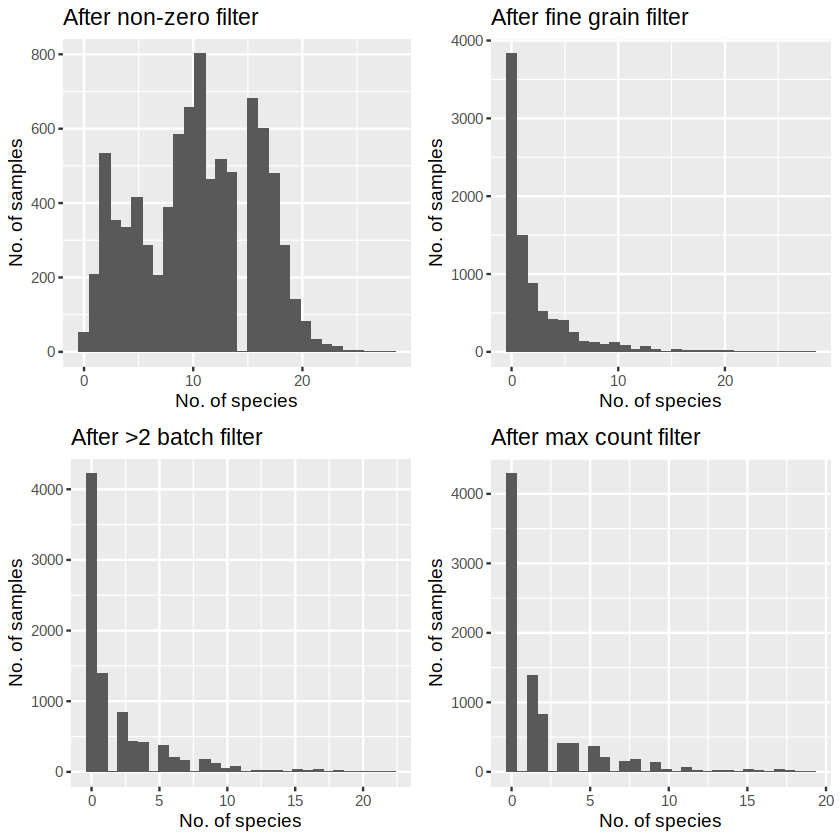

In [14]:
# After non-zero filter
tax_plt <- tibble(n = rowSums(prev_df %>% select(-npm_research_id))) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After non-zero filter")

# After fine grain decontamination
tax_plt1 <- tibble(n = rowSums(prev_zeroed %>% select(-npm_research_id))) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After fine grain filter")

# After simple batch filter
species_prev_filt2 <- prev_zeroed %>% select(all_of(batch_nc))
tax_plt2 <- tibble(n = rowSums(species_prev_filt2)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After >2 batch filter")

# After max count filter
species_prev_filt3 <- prev_zeroed %>% select(all_of(prev_max_filt$taxa))
tax_plt3 <- tibble(n = rowSums(species_prev_filt3)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After max count filter")


ggarrange(tax_plt, tax_plt1, tax_plt2, tax_plt3)

### Compare taxa with global analysis

In [15]:
global_stats <- fread("results/decontamination/global_decontamination_stats.csv")
global_taxa <- global_stats$taxa
fine_taxa <- prev_max_filt$taxa
venn_list <- list(global = global_taxa, fine = fine_taxa)

venn.diagram(venn_list, filename = "results/decontamination/global_versus_fine_grain_taxa.png",
             category.names = c("", ""),
             print.mode = c("raw", "percent"),
             fill = c("red", "blue")
             )

[1] 1

In [16]:
global_not_fine <- global_taxa[!(global_taxa %in% fine_taxa)]
fine_not_global <- fine_taxa[!(fine_taxa %in% global_taxa)]
fwrite(tibble(taxa = global_not_fine), "results/decontamination/global_not_fine_taxa.txt")
prev_max_filt %>% 
    filter(taxa %in% fine_not_global) %>%
    separate(taxa, into = c("genus", "species", "strain"), sep = " ", remove = F) %>%
    group_by(genus) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

Warning message:
“Expected 3 pieces. Additional pieces discarded in 1 rows [53].”
Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 41 rows [1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, ...].”


genus,n
<chr>,<int>
Methylobacterium,14
Pseudomonas,9
Sphingomonas,8
Bradyrhizobium,7
Ralstonia,4
Brevundimonas,3
Delftia,2
Herbaspirillum,2
Methylorubrum,2


#### Intersection of non-contaminants identified

In [20]:
prev_max_filt %>% 
    filter(taxa %in% intersect(fine_taxa, global_taxa))

prev_max_filt %>%
    separate(taxa, into = c("genus", "species", "strain"), sep = " ", remove = F) %>%
    filter(taxa %in% intersect(fine_taxa, global_taxa)) %>%
    group_by(genus) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

taxa,max_count,overall_prevalence,n_samples,max_bin
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Cutibacterium acnes,22588,0.033886503,292,>=500
Mitsuaria sp. 7,953,0.026807474,231,>=500
Bacillus cereus,39574,0.017059301,147,>=500
Moraxella osloensis,2378,0.016711152,144,>=500
Human mastadenovirus C,17476,0.014738308,127,>=500
Rhodococcus sp. NJ-530,281,0.010908669,94,100-500
Agrobacterium tumefaciens,871,0.010676570,92,>=500
Staphylococcus haemolyticus,79966,0.010560520,91,>=500
Gardnerella vaginalis,2183,0.009748172,84,>=500


Warning message:
“Expected 3 pieces. Additional pieces discarded in 11 rows [56, 72, 77, 79, 92, 98, 133, 160, 167, 178, 183].”
Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 133 rows [1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 25, 26, 27, ...].”


genus,n
<chr>,<int>
Deinococcus,9
Corynebacterium,7
Bifidobacterium,6
Staphylococcus,6
Microbacterium,5
Prevotella,5
Streptococcus,4
Acinetobacter,3
Agrobacterium,3


In [18]:
# species_df %>% 
#     filter(npm_research_id == "0416-0024") %>%
#     pivot_longer(!npm_research_id, names_to = "taxa", values_to = "read_count") %>%
#     arrange(desc(read_count))

[1] "WHH5104"


Bacillus cereus
<dbl>
1


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8470 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



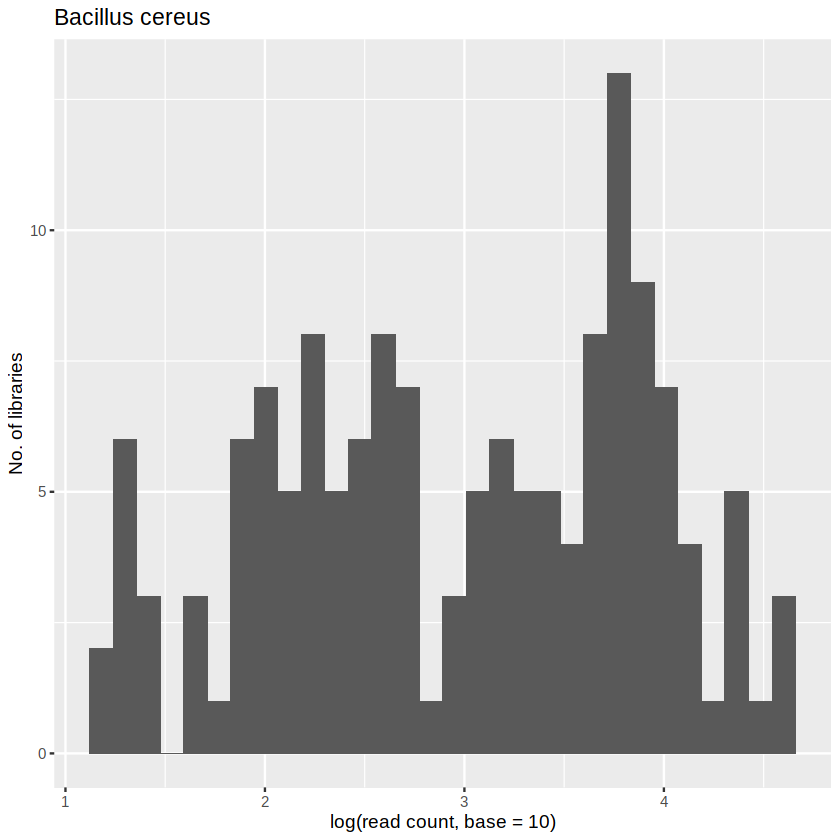

npm_research_id,Bacillus cereus
<chr>,<dbl>
WHH5104,39574
WHB534,38940
WHH5150,37057
WHB733,27909
WHB873,25309
WHH5146,23122
WHB879,22721
WHB880,22170
WHH5188,21117


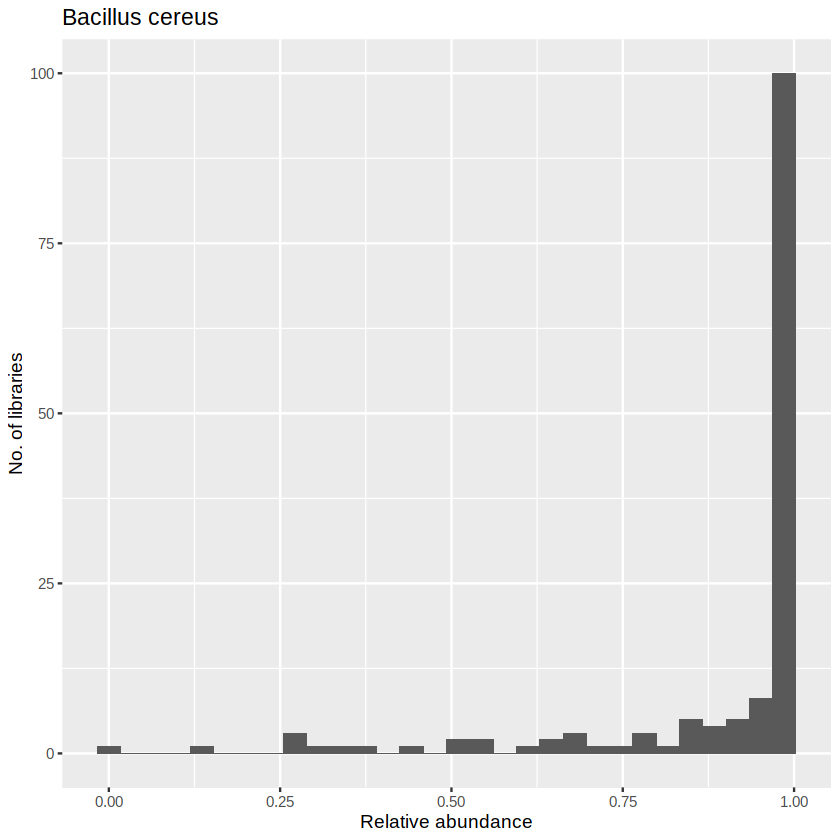

In [34]:
# taxon <- "Gardnerella vaginalis"
taxon <- "Bacillus cereus"
# taxon <- "Human mastadenovirus C"
# taxon <- "Cutibacterium acnes"
# taxon <- "Staphylococcus haemolyticus"
# taxon <- "Pseudomonas mendocina"
# taxon <- "Achromobacter xylosoxidans"
# taxon <- "Fusobacterium nucleatum"
# taxon <- "Ralstonia solanacearum"
# taxon <- "Paracoccus yeei"
# taxon <- "Neisseria subflava"
# taxon <- "Haemophilus parainfluenzae"
# taxon <- "Rickettsia felis"
# taxon <- "Corynebacterium segmentosum"
# taxon <- "Enterobacter cloacae"
# taxon <- "Staphylococcus epidermidis"
# taxon <- "Staphylococcus cohnii"
# taxon <- "Pseudomonas stutzeri"
# taxon <- "Microbacterium sp. Y-01"
# taxon <- "Lactobacillus crispatus"
# taxon <- "Acinetobacter baumannii"
# taxon <- "Microbacterium paraoxydans"
# taxon <- "Fusobacterium periodonticum"
# taxon <- "Microbacterium sp. PM5"
max_count <- prev_max_filt[prev_max_filt$taxa == taxon, ]$max_count

id <- (species_zeroed %>%
    filter(get(taxon) == max_count))$npm_research_id
print(id)

species_RA_filt <- otu_to_RA(species_zeroed %>% select(all_of(c("npm_research_id", prev_max_filt$taxa))))
species_RA_filt %>% 
    filter(npm_research_id == id) %>%
    select(all_of(c(taxon)))

species_zeroed %>%
    select(all_of(c("npm_research_id", taxon))) %>%
    arrange(desc(get(taxon))) %>%
#     filter(get(taxon) > 100) %>%
    ggplot(aes(x = log(get(taxon), base = 10))) +
    geom_histogram() +
    labs(x = "log(read count, base = 10)", y = "No. of libraries", title = taxon)

species_RA_filt %>% 
    select(all_of(c(taxon))) %>%
    filter(get(taxon) > 0) %>%
    ggplot(aes(x = get(taxon))) +
    geom_histogram() +
    labs(x = "Relative abundance", y = "No. of libraries", title = taxon)

species_zeroed %>% 
    filter(get(taxon) > 0) %>%
    select(all_of(c("npm_research_id", taxon))) %>%
    arrange(desc(get(taxon)))